<H3>EXPERIMENT 5 Perceptron vs Multilayer Perceptron (A/B Experiment) with Hyperparameter Tuning</H3>


Importing all necessary modules and function


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ----------------------------
# Step 1: Load CSV + Images
# ----------------------------
# img_folder = "Img" # This is not needed as the image path in the CSV is already relative

df = pd.read_csv(r'/content/drive/MyDrive/ML_Experiment5/english.csv')

# Map labels to numeric values (0,1,2,...,61)
label_to_id = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
id_to_label = {v: k for k, v in label_to_id.items()}
df['label'] = df['label'].map(label_to_id)

X, y = [], []

for idx, row in df.iterrows():
    # Construct the full path to the image by joining the base directory with the image path from the dataframe
    img_path = os.path.join('/content/drive/MyDrive/ML_Experiment5/', row['image'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # grayscale

    if img is not None: # Check if the image was loaded successfully
        img = cv2.resize(img, (28,28))                   # resize
        img = img.flatten() / 255.0                      # flatten + normalize
        X.append(img)
        y.append(row['label'])
    else:
        print(f"Warning: Could not load image from path: {img_path}")


X = np.array(X)
y = np.array(y)

# ----------------------------
# Step 2: Train/Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# Step 3: One-vs-Rest PLA Functions
# ----------------------------
def step_function(z):
    return np.where(z >= 0, 1, 0)

def train_pla_ovr(X, y, num_classes, lr=0.01, epochs=10):
    weights = np.zeros((num_classes, X.shape[1]))
    biases = np.zeros(num_classes)

    for c in range(num_classes):
        y_binary = np.where(y == c, 1, 0)  # binary labels for class c
        for _ in range(epochs):
            for xi, target in zip(X, y_binary):
                z = np.dot(xi, weights[c]) + biases[c]
                y_pred = step_function(z)
                update = lr * (target - y_pred)
                weights[c] += update * xi
                biases[c] += update
    return weights, biases

def predict_pla_ovr(X, weights, biases):
    scores = np.dot(X, weights.T) + biases
    return np.argmax(scores, axis=1)

# ----------------------------
# Step 4: Hyperparameter Tuning
# ----------------------------
learning_rates = [0.001, 0.01, 0.1]
epoch_list = [5, 10, 20]

best_acc = 0
best_params = None
best_model = None

for lr in learning_rates:
    for epochs in epoch_list:
        print(f"Training with lr={lr}, epochs={epochs} ...")
        weights, biases = train_pla_ovr(X_train, y_train, len(label_to_id), lr=lr, epochs=epochs)
        y_pred = predict_pla_ovr(X_test, weights, biases)
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (lr, epochs)
            best_model = (weights, biases)

print("\n✅ Best Hyperparameters:")
print("Learning Rate:", best_params[0])
print("Epochs:", best_params[1])
print("Best Accuracy:", best_acc)

# ----------------------------
# Step 5: Final Evaluation
# ----------------------------
final_weights, final_biases = best_model
y_pred_final = predict_pla_ovr(X_test, final_weights, final_biases)

print("\nClassification Report:\n", classification_report(y_test, y_pred_final, target_names=[id_to_label[i] for i in range(len(label_to_id))]))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_final))

Training with lr=0.001, epochs=5 ...
Accuracy: 0.0630
Training with lr=0.001, epochs=10 ...
Accuracy: 0.1232
Training with lr=0.001, epochs=20 ...
Accuracy: 0.1584
Training with lr=0.01, epochs=5 ...
Accuracy: 0.0630
Training with lr=0.01, epochs=10 ...
Accuracy: 0.1232
Training with lr=0.01, epochs=20 ...
Accuracy: 0.1598
Training with lr=0.1, epochs=5 ...
Accuracy: 0.0630
Training with lr=0.1, epochs=10 ...
Accuracy: 0.1232
Training with lr=0.1, epochs=20 ...
Accuracy: 0.1598

✅ Best Hyperparameters:
Learning Rate: 0.01
Epochs: 20
Best Accuracy: 0.1598240469208211

Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.07      0.07        14
           1       0.00      0.00      0.00        11
           2       0.27      0.30      0.29        10
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        16
           6       0.08

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
acc = accuracy_score(y_test, y_pred_final)

# Recall (macro average = equally weights all classes)
recall = recall_score(y_test, y_pred_final, average='macro')

# F1-score (macro average)
f1 = f1_score(y_test, y_pred_final, average='macro')

print(f"\nFinal Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Final Metrics:
Accuracy : 0.1598
Recall   : 0.1748
F1 Score : 0.1355


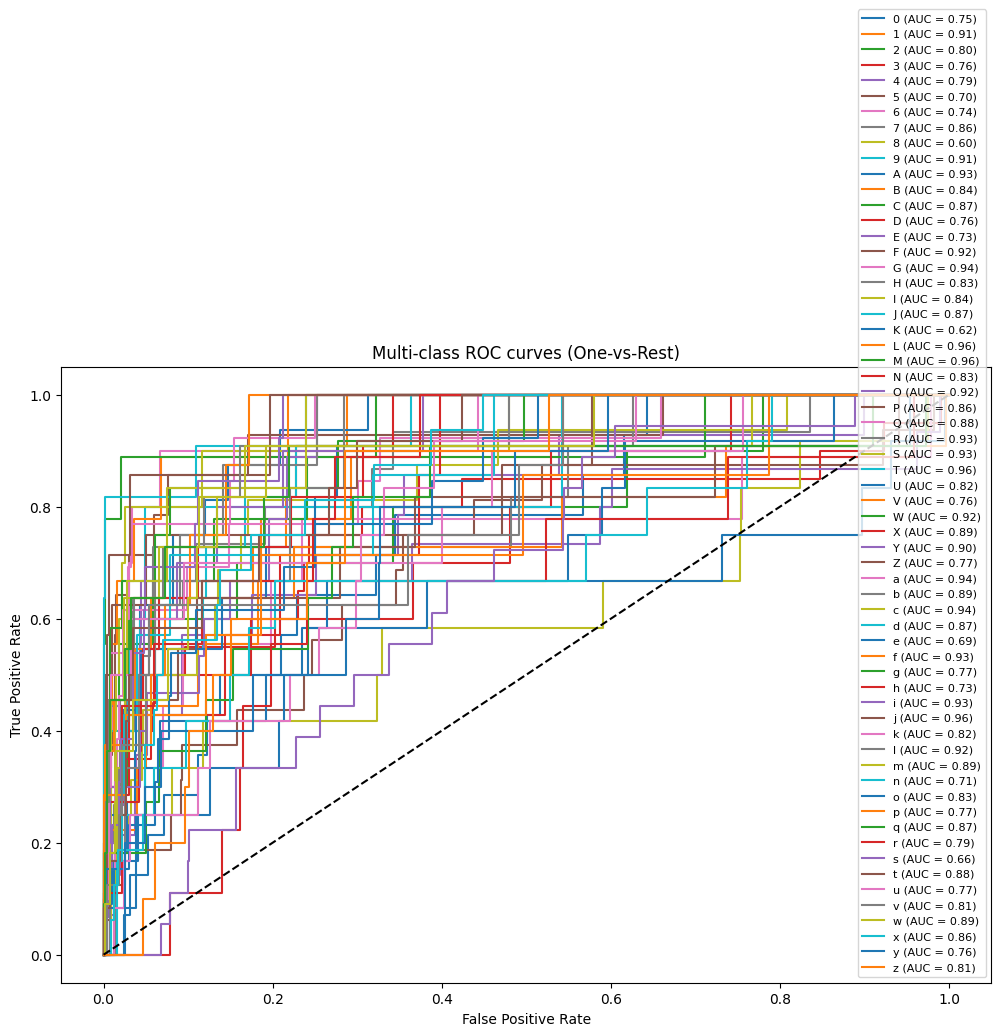

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ----------------------------
# Step 1: Binarize the labels for ROC
# ----------------------------
num_classes = len(label_to_id)
y_test_bin = label_binarize(y_test, classes=range(num_classes))
y_pred_scores = np.dot(X_test, final_weights.T) + final_biases  # use scores before step function

# ----------------------------
# Step 2: Plot ROC curves for each class
# ----------------------------
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id_to_label[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize=8)
plt.show()




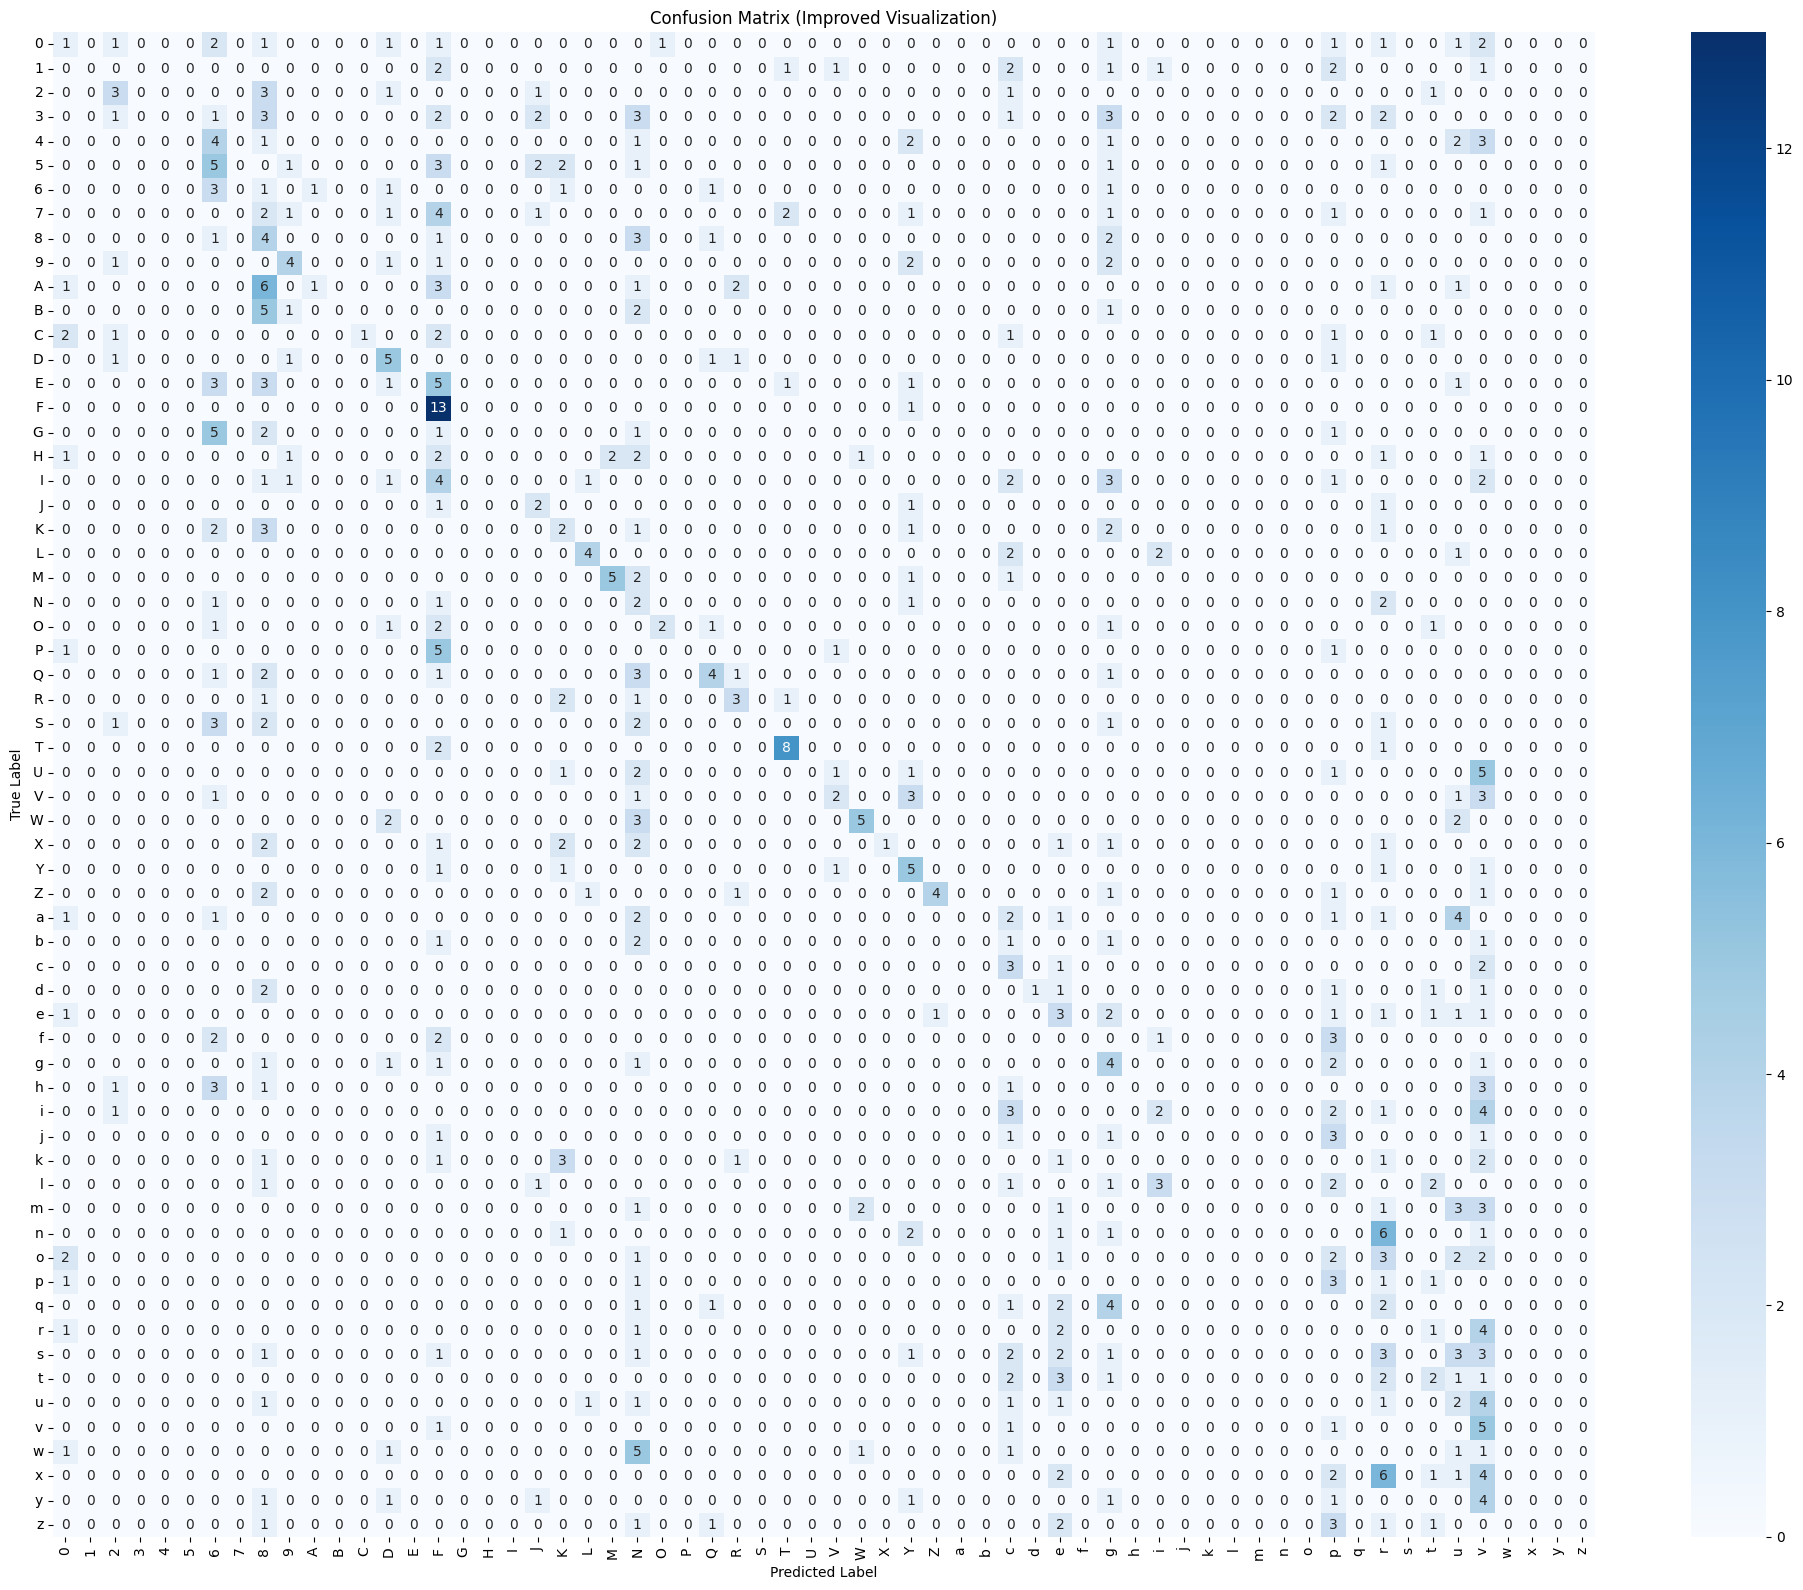

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Set figure size based on number of classes
plt.figure(figsize=(20, 16))

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id_to_label[i] for i in range(len(label_to_id))],
            yticklabels=[id_to_label[i] for i in range(len(label_to_id))],
            cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Improved Visualization)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

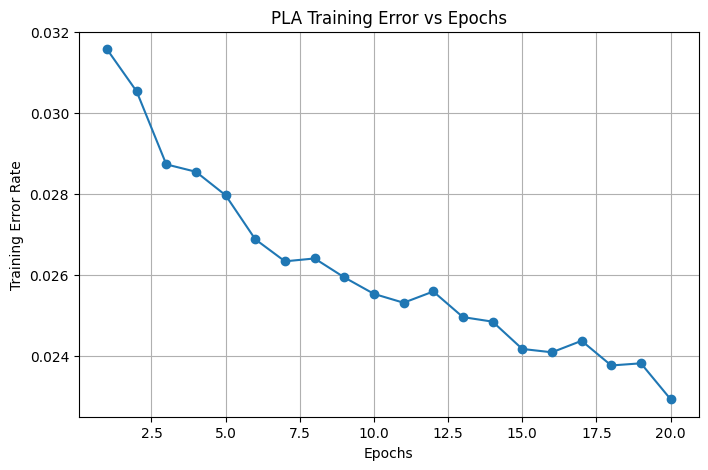

In [ ]:
# ----------------------------
# Step 3 (updated): PLA with error history
# ----------------------------
def train_pla_ovr(X, y, num_classes, lr=0.01, epochs=10):
    weights = np.zeros((num_classes, X.shape[1]))
    biases = np.zeros(num_classes)

    # store overall error per epoch
    error_history = []

    for epoch in range(epochs):
        total_errors = 0

        for c in range(num_classes):
            y_binary = np.where(y == c, 1, 0)
            for xi, target in zip(X, y_binary):
                z = np.dot(xi, weights[c]) + biases[c]
                y_pred = 1 if z >= 0 else 0
                update = lr * (target - y_pred)
                if update != 0:
                    total_errors += 1
                weights[c] += update * xi
                biases[c] += update

        # error rate = total errors / (samples × classes)
        error_rate = total_errors / (len(y) * num_classes)
        error_history.append(error_rate)

    return weights, biases, error_history


# ----------------------------
# After training loop
# ----------------------------
weights, biases, error_history = train_pla_ovr(X_train, y_train, len(label_to_id), lr=0.01, epochs=20)

# ----------------------------
# Plot Training Error vs Epochs
# ----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(error_history)+1), error_history, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Training Error Rate")
plt.title("PLA Training Error vs Epochs")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/30 - Train Acc: 0.0170, Val Acc: 0.0165, Train Loss: 4.2376, Val Loss: 4.1458
Epoch 2/30 - Train Acc: 0.0229, Val Acc: 0.0147, Train Loss: 4.1498, Val Loss: 4.1309


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 3/30 - Train Acc: 0.0160, Val Acc: 0.0165, Train Loss: 4.1376, Val Loss: 4.1295
Epoch 4/30 - Train Acc: 0.0142, Val Acc: 0.0110, Train Loss: 4.1226, Val Loss: 4.1195


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 5/30 - Train Acc: 0.0247, Val Acc: 0.0183, Train Loss: 4.1161, Val Loss: 4.1049
Epoch 6/30 - Train Acc: 0.0399, Val Acc: 0.0403, Train Loss: 4.0892, Val Loss: 4.0910


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 7/30 - Train Acc: 0.0500, Val Acc: 0.0385, Train Loss: 4.0703, Val Loss: 4.0619
Epoch 8/30 - Train Acc: 0.0509, Val Acc: 0.0348, Train Loss: 4.0509, Val Loss: 4.0528


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 9/30 - Train Acc: 0.0555, Val Acc: 0.0458, Train Loss: 4.0279, Val Loss: 4.0105
Epoch 10/30 - Train Acc: 0.0632, Val Acc: 0.0513, Train Loss: 3.9850, Val Loss: 3.9932


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 11/30 - Train Acc: 0.0623, Val Acc: 0.0623, Train Loss: 3.9612, Val Loss: 3.9622
Epoch 12/30 - Train Acc: 0.0958, Val Acc: 0.0806, Train Loss: 3.9056, Val Loss: 3.9245


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 13/30 - Train Acc: 0.0880, Val Acc: 0.0733, Train Loss: 3.8705, Val Loss: 3.8833
Epoch 14/30 - Train Acc: 0.0953, Val Acc: 0.0824, Train Loss: 3.8290, Val Loss: 3.8500


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 15/30 - Train Acc: 0.0807, Val Acc: 0.0769, Train Loss: 3.7709, Val Loss: 3.8115
Epoch 16/30 - Train Acc: 0.1082, Val Acc: 0.1081, Train Loss: 3.7286, Val Loss: 3.7744


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 17/30 - Train Acc: 0.1201, Val Acc: 0.1044, Train Loss: 3.6782, Val Loss: 3.7198
Epoch 18/30 - Train Acc: 0.1320, Val Acc: 0.1062, Train Loss: 3.6202, Val Loss: 3.6995


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 19/30 - Train Acc: 0.1370, Val Acc: 0.1190, Train Loss: 3.6184, Val Loss: 3.6396
Epoch 20/30 - Train Acc: 0.1453, Val Acc: 0.1300, Train Loss: 3.5505, Val Loss: 3.6223


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 21/30 - Train Acc: 0.1503, Val Acc: 0.1264, Train Loss: 3.5529, Val Loss: 3.5892


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 22/30 - Train Acc: 0.1567, Val Acc: 0.1319, Train Loss: 3.4653, Val Loss: 3.5609


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 23/30 - Train Acc: 0.1806, Val Acc: 0.1630, Train Loss: 3.4421, Val Loss: 3.5482


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 24/30 - Train Acc: 0.1664, Val Acc: 0.1264, Train Loss: 3.4534, Val Loss: 3.5132


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 25/30 - Train Acc: 0.1613, Val Acc: 0.1319, Train Loss: 3.3616, Val Loss: 3.4996


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 26/30 - Train Acc: 0.1787, Val Acc: 0.1667, Train Loss: 3.3407, Val Loss: 3.4925


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 27/30 - Train Acc: 0.1852, Val Acc: 0.1447, Train Loss: 3.3221, Val Loss: 3.4770


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 28/30 - Train Acc: 0.1897, Val Acc: 0.1667, Train Loss: 3.3112, Val Loss: 3.4274


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 29/30 - Train Acc: 0.2122, Val Acc: 0.1722, Train Loss: 3.2839, Val Loss: 3.4242


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being

Epoch 30/30 - Train Acc: 0.1810, Val Acc: 0.1593, Train Loss: 3.2771, Val Loss: 3.4188

✅ Final Test Metrics:
Accuracy : 0.1334
Recall   : 0.1334
F1 Score : 0.1191

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.14      0.09      0.11        11
           2       0.06      0.18      0.09        11
           3       0.05      0.09      0.06        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.20      0.09      0.12        11
           7       0.00      0.00      0.00        11
           8       0.18      0.64      0.29        11
           9       0.09      0.27      0.13        11
           A       0.29      0.18      0.22        11
           B       0.22      0.18      0.20        11
           C       0.09      0.09      0.09        11
           D       0.00      0.00      0.00        11


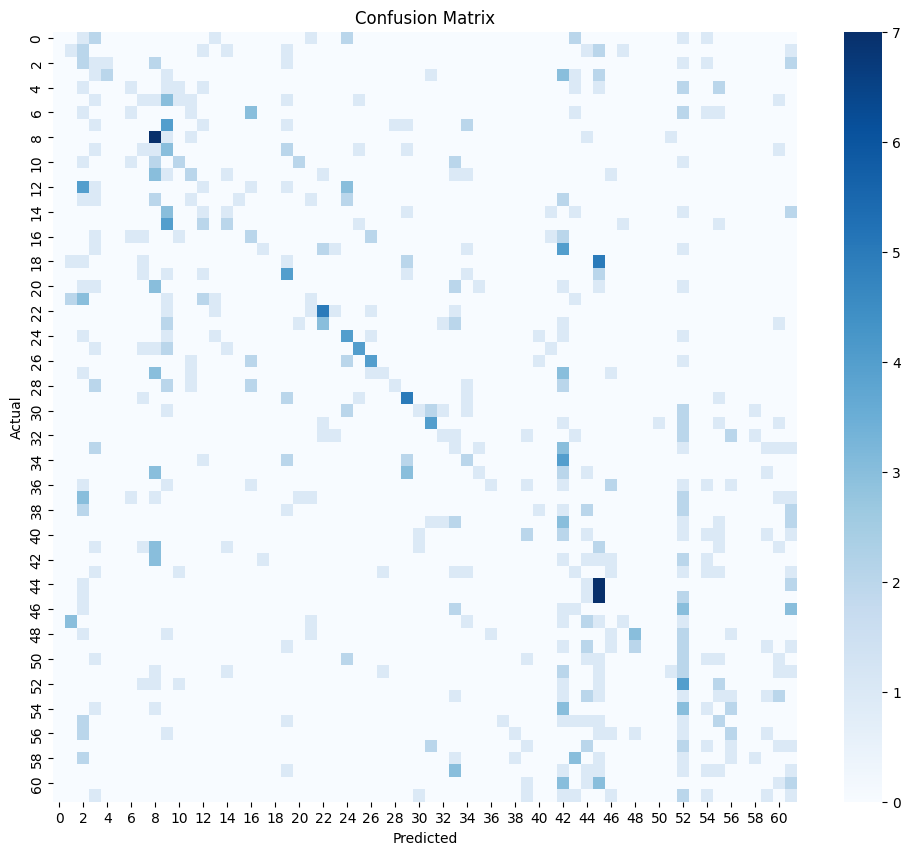

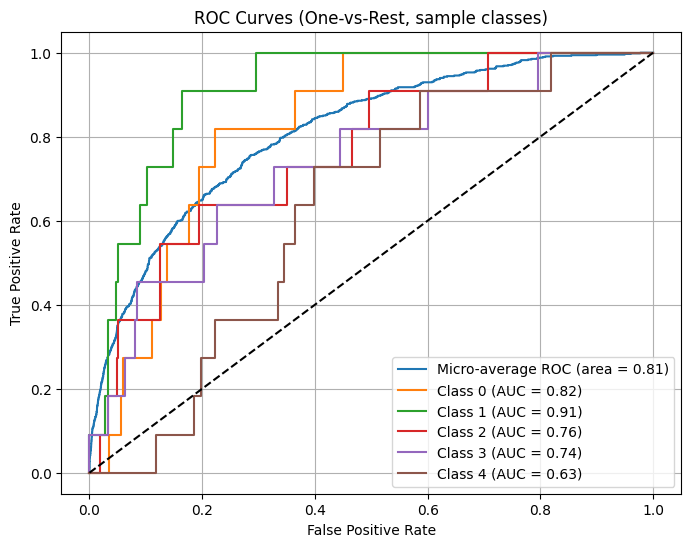

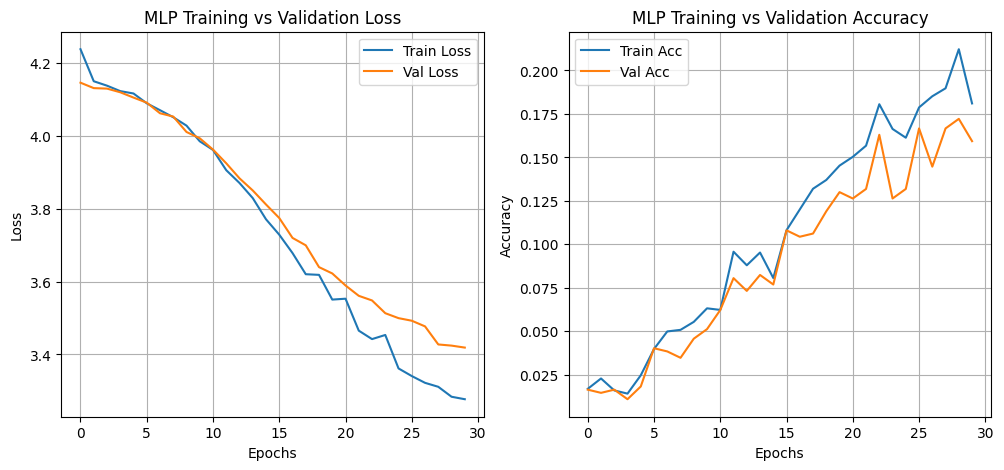

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    recall_score, f1_score, log_loss, roc_curve, auc
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize

# ----------------------------
# Step 1: Load CSV + Images
# ----------------------------
df = pd.read_csv(r'/content/drive/MyDrive/ML_Experiment5/english.csv')

label_to_id = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
id_to_label = {v: k for k, v in label_to_id.items()}
df['label'] = df['label'].map(label_to_id)

X, y = [], []
for idx, row in df.iterrows():
    img_path = os.path.join('/content/drive/MyDrive/ML_Experiment5/', row['image'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (28, 28))
        img = img.flatten() / 255.0
        X.append(img)
        y.append(row['label'])
X = np.array(X)
y = np.array(y)

# ----------------------------
# Step 2: Train/Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# further split training into train+val for curves
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ----------------------------
# Step 3: Train MLP epoch by epoch
# ----------------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1,          # one epoch per .fit()
    warm_start=True,     # continue training
    random_state=42
)

epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    mlp.fit(X_tr, y_tr)

    # Training metrics
    y_tr_pred = mlp.predict(X_tr)
    train_acc = accuracy_score(y_tr, y_tr_pred)
    train_loss = mlp.loss_

    # Validation metrics
    y_val_pred = mlp.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_loss = log_loss(y_val, mlp.predict_proba(X_val))

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} "
          f"- Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# ----------------------------
# Step 4: Final Evaluation on Test Set
# ----------------------------
y_pred = mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n✅ Final Test Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nClassification Report:\n", classification_report(
    y_test, y_pred, target_names=[id_to_label[i] for i in range(len(label_to_id))]
))

# ----------------------------
# Step 5: Confusion Matrix (Heatmap)
# ----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ----------------------------
# Step 6: ROC Curves (One-vs-Rest)
# ----------------------------
y_test_bin = label_binarize(y_test, classes=list(range(len(label_to_id))))
y_score = mlp.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (area = {roc_auc["micro"]:.2f})')

# Plot a few example classes
for i in range(min(5, n_classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {id_to_label[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest, sample classes)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ----------------------------
# Step 7: Training vs Validation Curves
# ----------------------------
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("MLP Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()


Epoch 1/30 - Train Acc: 0.0174, Val Acc: 0.0092, Train Loss: 4.1404, Val Loss: 4.1305
Epoch 2/30 - Train Acc: 0.0137, Val Acc: 0.0147, Train Loss: 4.1299, Val Loss: 4.1281
Epoch 3/30 - Train Acc: 0.0170, Val Acc: 0.0147, Train Loss: 4.1259, Val Loss: 4.1198
Epoch 4/30 - Train Acc: 0.0215, Val Acc: 0.0220, Train Loss: 4.1156, Val Loss: 4.1096
Epoch 5/30 - Train Acc: 0.0229, Val Acc: 0.0348, Train Loss: 4.0954, Val Loss: 4.0685
Epoch 6/30 - Train Acc: 0.0394, Val Acc: 0.0311, Train Loss: 4.0351, Val Loss: 4.0110
Epoch 7/30 - Train Acc: 0.0458, Val Acc: 0.0549, Train Loss: 3.9395, Val Loss: 3.8788
Epoch 8/30 - Train Acc: 0.0660, Val Acc: 0.0549, Train Loss: 3.7968, Val Loss: 3.7671
Epoch 9/30 - Train Acc: 0.0793, Val Acc: 0.0696, Train Loss: 3.6641, Val Loss: 3.6939
Epoch 10/30 - Train Acc: 0.0866, Val Acc: 0.0989, Train Loss: 3.5928, Val Loss: 3.5924
Epoch 11/30 - Train Acc: 0.0825, Val Acc: 0.0989, Train Loss: 3.5584, Val Loss: 3.5459
Epoch 12/30 - Train Acc: 0.0976, Val Acc: 0.0916, Tr

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


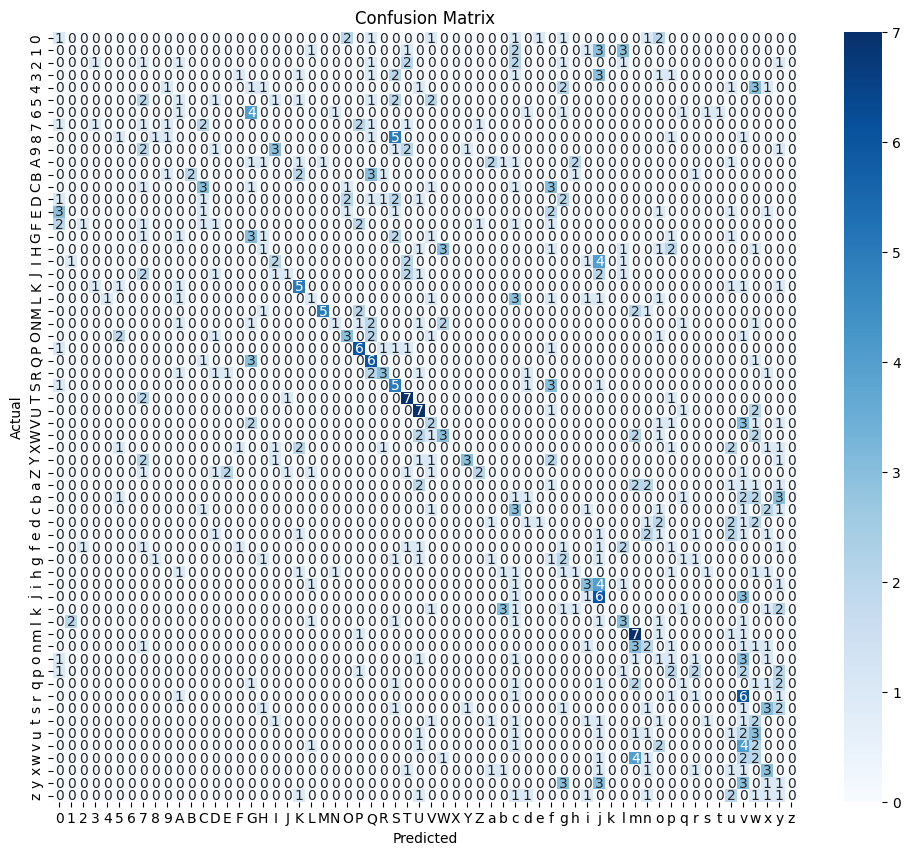

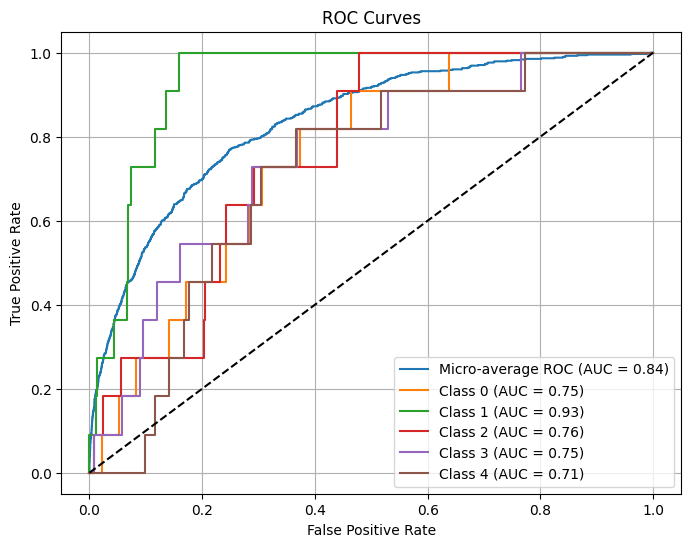

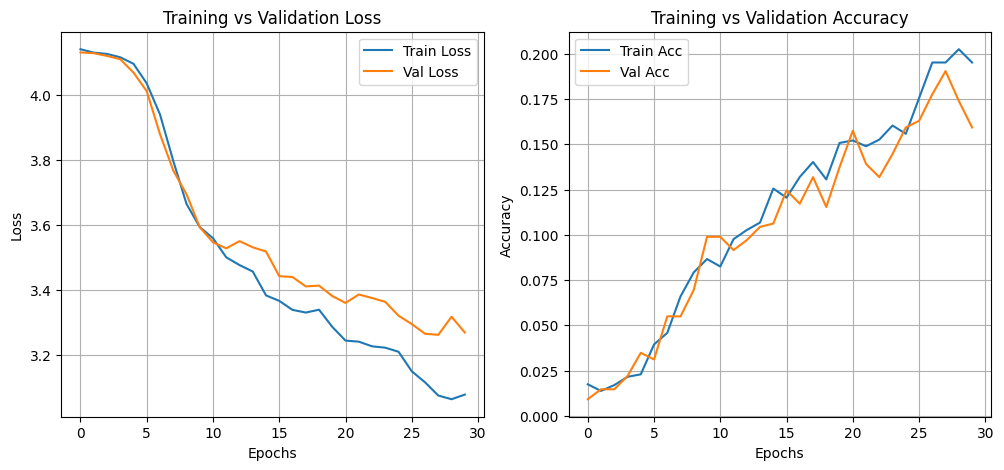

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# ----------------------------
# Step 1: Load CSV + Images
# ----------------------------
df = pd.read_csv(r'/content/drive/MyDrive/ML_Experiment5/english.csv')

label_to_id = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
id_to_label = {v: k for k, v in label_to_id.items()}
df['label'] = df['label'].map(label_to_id)

X, y = [], []
for _, row in df.iterrows():
    img_path = os.path.join('/content/drive/MyDrive/ML_Experiment5/', row['image'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (28, 28))
        img = img.flatten() / 255.0
        X.append(img)
        y.append(row['label'])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)

# ----------------------------
# Step 2: Train/Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ----------------------------
# Step 3: PyTorch Dataset & DataLoader
# ----------------------------
class ImgDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(ImgDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ImgDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(ImgDataset(X_test, y_test), batch_size=batch_size)

# ----------------------------
# Step 4: Define MLP in PyTorch
# ----------------------------
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(28*28, 128, 64, len(label_to_id)).to(device)

# ----------------------------
# Step 5: Loss & Optimizer
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------------------
# Step 6: Training Loop
# ----------------------------
epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb)
            loss = criterion(outputs, yb)

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(yb).sum().item()
            total += yb.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# ----------------------------
# Step 7: Test Evaluation
# ----------------------------
model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        outputs = model(Xb)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

y_true, y_pred, y_score = np.array(y_true), np.array(y_pred), np.array(y_score)

print("\n✅ Final Test Metrics:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(
    y_true, y_pred, target_names=[id_to_label[i] for i in range(len(label_to_id))]
))

# ----------------------------
# Step 8: Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id_to_label[i] for i in range(len(label_to_id))],
            yticklabels=[id_to_label[i] for i in range(len(label_to_id))])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ----------------------------
# Step 9: ROC Curves
# ----------------------------
y_test_bin = label_binarize(y_true, classes=list(range(len(label_to_id))))
fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})')

for i in range(min(5, n_classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {id_to_label[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ----------------------------
# Step 10: Training Curves
# ----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import torch
import random

# -----------------------------
# Config
# -----------------------------
IMG_SIZE = (28, 28)
RANDOM_SEED = 42
NUM_CLASSES = 62
BASE_DIR = "/content/drive/MyDrive/ML_Experiment5"  # <-- your project folder

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# -----------------------------
# Load CSV
# -----------------------------
csv_path = os.path.join(BASE_DIR, "english.csv")
df = pd.read_csv(csv_path)
print("CSV columns:", df.columns)
print(df.head())

# -----------------------------
# Image Loader
# -----------------------------
def load_images_from_csv(csv_df, base_dir=BASE_DIR, img_size=(28,28)):
    X, y = [], []
    for _, row in csv_df.iterrows():
        rel_path = row["image"]                      # e.g., "Img/img001-001.png"
        full_path = os.path.join(base_dir, rel_path) # -> /content/.../ML_Experiment5/Img/img001-001.png
        if os.path.exists(full_path):
            img = Image.open(full_path).convert("L").resize(img_size)
            arr = np.array(img, dtype=np.float32) / 255.0
            X.append(arr.flatten())
            y.append(row["label"])
        else:
            print("Missing file:", full_path)
    return np.array(X), np.array(y)

# -----------------------------
# Load dataset
# -----------------------------
X, y_raw = load_images_from_csv(df, base_dir=BASE_DIR, img_size=IMG_SIZE)
print("Dataset:", X.shape, "Unique labels:", len(set(y_raw)))

# -----------------------------
# Encode labels & split
# -----------------------------
le = LabelEncoder()
y = le.fit_transform(y_raw)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# -----------------------------
# Normalize features
# -----------------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)


CSV columns: Index(['image', 'label'], dtype='object')
                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0
Dataset: (3410, 784) Unique labels: 62
Train: (2387, 784) Val: (511, 784) Test: (512, 784)


In [ ]:
import pandas as pd

df = pd.read_csv(r"/content/drive/MyDrive/ML_Experiment5/english.csv")
print(df.head())
print(df.columns)


                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0
Index(['image', 'label'], dtype='object')


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_classes, activation='relu', dropout=0.0):
        super().__init__()
        layers, prev = [], input_dim
        act_map = {'relu':nn.ReLU, 'tanh':nn.Tanh, 'sigmoid':nn.Sigmoid}
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), act_map[activation]()]
            if dropout>0: layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

In [ ]:
# Training Utilities
def make_loader(X, y, batch=64, shuffle=True):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle)

def train_epoch(model, loader, opt, device):
    model.train(); total=0
    for xb,yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = F.cross_entropy(out, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    return total/len(loader.dataset)

def eval_model(model, loader, device):
    model.eval(); preds, labs = [], []
    total=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            total += loss.item()*xb.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            labs.append(yb.cpu().numpy())
    return total/len(loader.dataset), np.concatenate(preds), np.concatenate(labs)

# Hyperparameter grid
hyperparams = {
    'hidden_layers': [[128], [256], [256,128], [512,256]],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [64, 128, 256],
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

# Train MLP
device = "cuda" if torch.cuda.is_available() else "cpu"

best_val_acc = 0
best_config = None
best_model_state = None

# Iterate over all hyperparameter combinations
for hl, act, do, lr, bs, opt_name in product(
    hyperparams['hidden_layers'],
    hyperparams['activation'],
    hyperparams['dropout'],
    hyperparams['lr'],
    hyperparams['batch_size'],
    hyperparams['optimizer']
):
    # Prepare loaders with current batch size
    train_loader = make_loader(X_train_s, y_train, batch=bs)
    val_loader = make_loader(X_val_s, y_val, batch=bs, shuffle=False)

    # Initialize model and optimizer
    model = MLP(X_train_s.shape[1], hl, NUM_CLASSES, activation=act, dropout=do).to(device)
    if opt_name == 'adam':
        opt = optim.Adam(model.parameters(), lr=lr)
    elif opt_name == 'sgd':
        opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  # momentum is standard for SGD
    elif opt_name == 'rmsprop':
        opt = optim.RMSprop(model.parameters(), lr=lr)

    # Train for a few epochs (e.g., 5 for tuning speed)
    for epoch in range(5):
        train_epoch(model, train_loader, opt, device)

    # Evaluate on validation set
    _, y_val_pred, y_val_true = eval_model(model, val_loader, device)
    val_acc = (y_val_pred == y_val_true).mean()

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = {'hidden_layers': hl, 'activation': act, 'dropout': do, 'lr': lr, 'batch_size': bs, 'optimizer': opt_name}
        best_model_state = model.state_dict()

print("Best hyperparameters:", best_config, "Validation Accuracy:", best_val_acc)

train_loader = make_loader(X_train_s, y_train, batch=best_config['batch_size'])
val_loader = make_loader(X_val_s, y_val, batch=best_config['batch_size'], shuffle=False)
test_loader = make_loader(X_test_s, y_test, batch=best_config['batch_size'], shuffle=False)

model = MLP(X_train_s.shape[1], best_config['hidden_layers'], NUM_CLASSES,
            activation=best_config['activation'], dropout=best_config['dropout']).to(device)
model.load_state_dict(best_model_state)  # Optionally start from tuned weights

if best_config['optimizer'] == 'adam':
    opt = optim.Adam(model.parameters(), lr=best_config['lr'])
elif best_config['optimizer'] == 'sgd':
    opt = optim.SGD(model.parameters(), lr=best_config['lr'], momentum=0.9)
elif best_config['optimizer'] == 'rmsprop':
    opt = optim.RMSprop(model.parameters(), lr=best_config['lr'])

history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(20):
    tl = train_epoch(model, train_loader, opt, device)
    vl, vp, vlabs = eval_model(model, val_loader, device)
    acc = (vp==vlabs).mean()
    history['train_loss'].append(tl); history['val_loss'].append(vl); history['val_acc'].append(acc)
    print(f"Epoch {epoch+1}: train={tl:.3f}, val={vl:.3f}, acc={acc:.3f}")


Best hyperparameters: {'hidden_layers': [512, 256], 'activation': 'relu', 'dropout': 0.0, 'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam'} Validation Accuracy: 0.46966731898238745
Epoch 1: train=1.041, val=2.398, acc=0.481
Epoch 2: train=0.783, val=2.383, acc=0.499
Epoch 3: train=0.649, val=2.470, acc=0.515
Epoch 4: train=0.524, val=2.546, acc=0.509
Epoch 5: train=0.420, val=2.543, acc=0.528
Epoch 6: train=0.363, val=2.670, acc=0.503
Epoch 7: train=0.318, val=2.752, acc=0.521
Epoch 8: train=0.245, val=2.798, acc=0.538
Epoch 9: train=0.185, val=2.853, acc=0.534
Epoch 10: train=0.171, val=3.078, acc=0.544
Epoch 11: train=0.202, val=3.273, acc=0.503
Epoch 12: train=0.160, val=3.200, acc=0.519
Epoch 13: train=0.121, val=3.237, acc=0.524
Epoch 14: train=0.081, val=3.190, acc=0.536
Epoch 15: train=0.065, val=3.251, acc=0.524
Epoch 16: train=0.053, val=3.320, acc=0.550
Epoch 17: train=0.045, val=3.409, acc=0.542
Epoch 18: train=0.044, val=3.432, acc=0.532
Epoch 19: train=0.037, val=3.438, 

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.22      0.25      0.24         8
           2       0.56      0.62      0.59         8
           3       0.60      0.75      0.67         8
           4       0.50      0.50      0.50         8
           5       0.33      0.25      0.29         8
           6       0.45      0.62      0.53         8
           7       0.64      0.78      0.70         9
           8       0.57      1.00      0.73         8
           9       0.36      0.62      0.45         8
          10       0.62      0.62      0.62         8
          11       0.62      0.56      0.59         9
          12       0.75      0.75      0.75         8
          13       0.71      0.62      0.67         8
          14       0.57      0.50      0.53         8
          15       0.71      0.62      0.67         8
          16       0.86      0.75      0.80         8

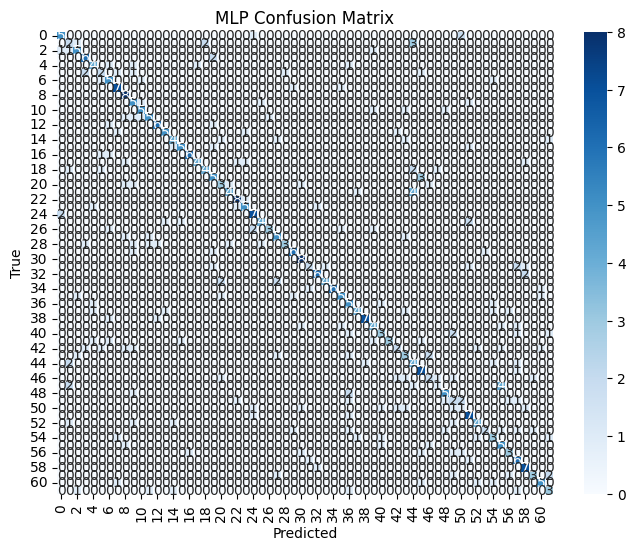

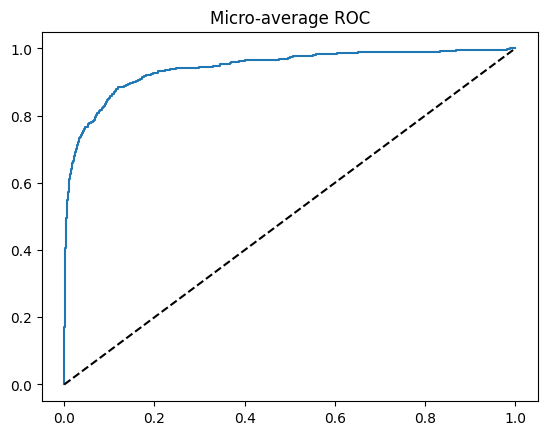

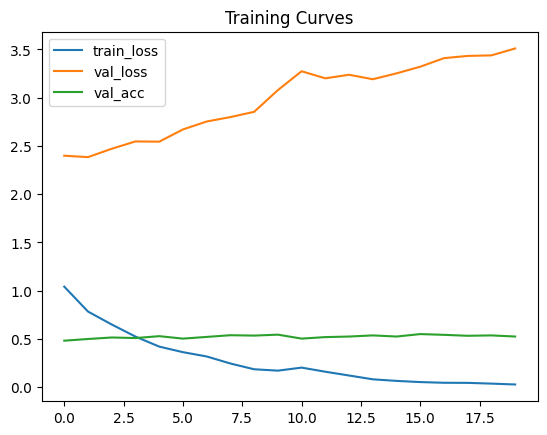

In [ ]:
# Evaluation (MLP vs PLA)
# Test set
_, y_pred_mlp, _ = eval_model(model, test_loader, device)
print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))

# Confusion Matrix Example (MLP)
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



# ROC (micro-average)
def predict_proba(model, loader):
    model.eval(); out=[]
    with torch.no_grad():
        for xb,_ in loader:
            logits = model(xb.to(device))
            out.append(F.softmax(logits,1).cpu().numpy())
    return np.vstack(out)

probs = predict_proba(model, test_loader)
y_onehot = np.eye(NUM_CLASSES)[y_test]
fpr,tpr,_ = roc_curve(y_onehot.ravel(), probs.ravel())
plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'k--')
plt.title("Micro-average ROC"); plt.show()

# Plot Training Curves
plt.plot(history['train_loss'], label="train_loss")
plt.plot(history['val_loss'], label="val_loss")
plt.plot(history['val_acc'], label="val_acc")
plt.legend(); plt.title("Training Curves"); plt.show()
